CODE BLOCK: 1

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [6]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [7]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7MB/s]


CODE BLOCK: 5

In [8]:
batch_size = 64

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

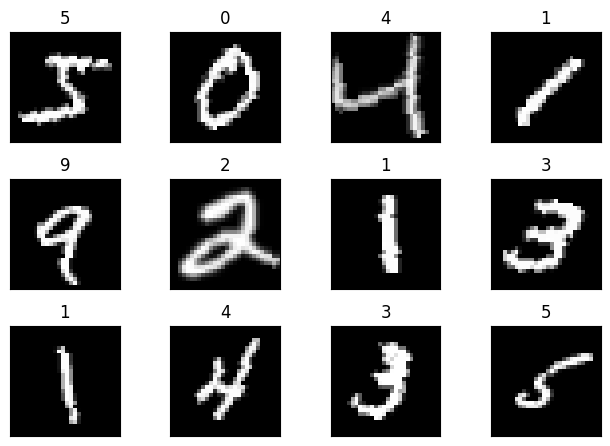

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

debug = False

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input: [1, 28, 28]
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)    # -> [32, 26, 26], RF=3
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 16, kernel_size=3)   # -> [16, 24, 24], RF=5
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3)   # -> [16, 22, 22], RF=7
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 16, kernel_size=3)   # -> [16, 9, 9], RF=12 (after pool)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.Conv2d(16, 16, kernel_size=3)   # -> [16, 7, 7], RF=16
        self.bn5 = nn.BatchNorm2d(16)

        # Extra convs to expand RF
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, padding=1)  # -> [16, 3, 3], RF=26
        self.bn6 = nn.BatchNorm2d(16)

        self.conv7 = nn.Conv2d(16, 12, kernel_size=3, padding=1)  # -> [12, 3, 3], RF=34
        self.bn7 = nn.BatchNorm2d(12)

        # Final FC: flatten [12, 3, 3] -> 108
        self.fc1 = nn.Linear(12 * 3 * 3, 10)

    def forward(self, x):
        # Input: [1, 28, 28]
        x = F.relu(self.bn1(self.conv1(x)))  # -> [32, 26, 26], RF=3
        if debug: print(x.shape)

        x = F.relu(self.bn2(self.conv2(x)))  # -> [16, 24, 24], RF=5
        if debug: print(x.shape)

        x = F.relu(self.bn3(self.conv3(x)))  # -> [16, 22, 22], RF=7
        x = F.max_pool2d(x, 2)               # -> [16, 11, 11], RF=8
        if debug: print(x.shape)

        x = F.relu(self.bn4(self.conv4(x)))  # -> [16, 9, 9], RF=12
        if debug: print(x.shape)

        x = F.relu(self.bn5(self.conv5(x)))  # -> [16, 7, 7], RF=16
        x = F.max_pool2d(x, 2)               # -> [16, 3, 3], RF=18
        if debug: print(x.shape)

        x = F.relu(self.bn6(self.conv6(x)))  # -> [16, 3, 3], RF=26
        x = F.relu(self.bn7(self.conv7(x)))  # -> [12, 3, 3], RF=34
        if debug: print(x.shape)

        x = x.view(-1, 12 * 3 * 3)           # flatten -> 108
        x = self.fc1(x)                      # -> [10]
        return F.log_softmax(x, dim=1)


In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 16, 24, 24]           4,624
       BatchNorm2d-4           [-1, 16, 24, 24]              32
            Conv2d-5           [-1, 16, 22, 22]           2,320
       BatchNorm2d-6           [-1, 16, 22, 22]              32
            Conv2d-7             [-1, 16, 9, 9]           2,320
       BatchNorm2d-8             [-1, 16, 9, 9]              32
            Conv2d-9             [-1, 16, 7, 7]           2,320
      BatchNorm2d-10             [-1, 16, 7, 7]              32
           Conv2d-11             [-1, 16, 3, 3]           2,320
      BatchNorm2d-12             [-1, 16, 3, 3]              32
           Conv2d-13             [-1, 12, 3, 3]           1,740
      BatchNorm2d-14             [-1, 1

CODE BLOCK: 8

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [13]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [14]:
device = 'cuda'
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.0419 Batch_id=937 Accuracy=94.33: 100%|██████████| 938/938 [00:32<00:00, 29.00it/s]


Test set: Average loss: 0.0013, Accuracy: 58419/60000 (97.36%)

Epoch 2


Train: Loss=0.0091 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:23<00:00, 39.12it/s]


Test set: Average loss: 0.0009, Accuracy: 58956/60000 (98.26%)

Epoch 3


Train: Loss=0.0037 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:24<00:00, 38.50it/s]


Test set: Average loss: 0.0008, Accuracy: 58986/60000 (98.31%)

Epoch 4


Train: Loss=0.0432 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:24<00:00, 38.61it/s]


Test set: Average loss: 0.0007, Accuracy: 59163/60000 (98.61%)

Epoch 5


Train: Loss=0.0152 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:24<00:00, 38.94it/s]


Test set: Average loss: 0.0006, Accuracy: 59227/60000 (98.71%)

Epoch 6


Train: Loss=0.0021 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:23<00:00, 39.67it/s]


Test set: Average loss: 0.0006, Accuracy: 59332/60000 (98.89%)

Epoch 7


Train: Loss=0.0231 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:23<00:00, 39.25it/s]


Test set: Average loss: 0.0005, Accuracy: 59392/60000 (98.99%)

Epoch 8


Train: Loss=0.0053 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:23<00:00, 39.24it/s]


Test set: Average loss: 0.0005, Accuracy: 59410/60000 (99.02%)

Epoch 9


Train: Loss=0.0497 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:23<00:00, 39.78it/s]


Test set: Average loss: 0.0005, Accuracy: 59408/60000 (99.01%)

Epoch 10


Train: Loss=0.0126 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:24<00:00, 38.90it/s]


Test set: Average loss: 0.0004, Accuracy: 59429/60000 (99.05%)

Epoch 11


Train: Loss=0.0026 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:24<00:00, 38.84it/s]


Test set: Average loss: 0.0005, Accuracy: 59359/60000 (98.93%)

Epoch 12


Train: Loss=0.0009 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:24<00:00, 38.53it/s]


Test set: Average loss: 0.0004, Accuracy: 59462/60000 (99.10%)

Epoch 13


Train: Loss=0.0011 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:24<00:00, 38.53it/s]


Test set: Average loss: 0.0004, Accuracy: 59480/60000 (99.13%)

Epoch 14


Train: Loss=0.0034 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:24<00:00, 38.58it/s]


Test set: Average loss: 0.0005, Accuracy: 59397/60000 (99.00%)

Epoch 15


Train: Loss=0.0213 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:24<00:00, 38.38it/s]


Test set: Average loss: 0.0004, Accuracy: 59479/60000 (99.13%)

Epoch 16


Train: Loss=0.0032 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:24<00:00, 38.97it/s]


Test set: Average loss: 0.0003, Accuracy: 59654/60000 (99.42%)

Epoch 17


Train: Loss=0.0006 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:23<00:00, 39.70it/s]


Test set: Average loss: 0.0003, Accuracy: 59661/60000 (99.44%)

Epoch 18


Train: Loss=0.0012 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [00:23<00:00, 39.20it/s]


Test set: Average loss: 0.0003, Accuracy: 59678/60000 (99.46%)

Epoch 19


Train: Loss=0.0015 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:23<00:00, 39.33it/s]


Test set: Average loss: 0.0003, Accuracy: 59701/60000 (99.50%)

Epoch 20


Train: Loss=0.0014 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:24<00:00, 38.84it/s]


Test set: Average loss: 0.0003, Accuracy: 59689/60000 (99.48%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

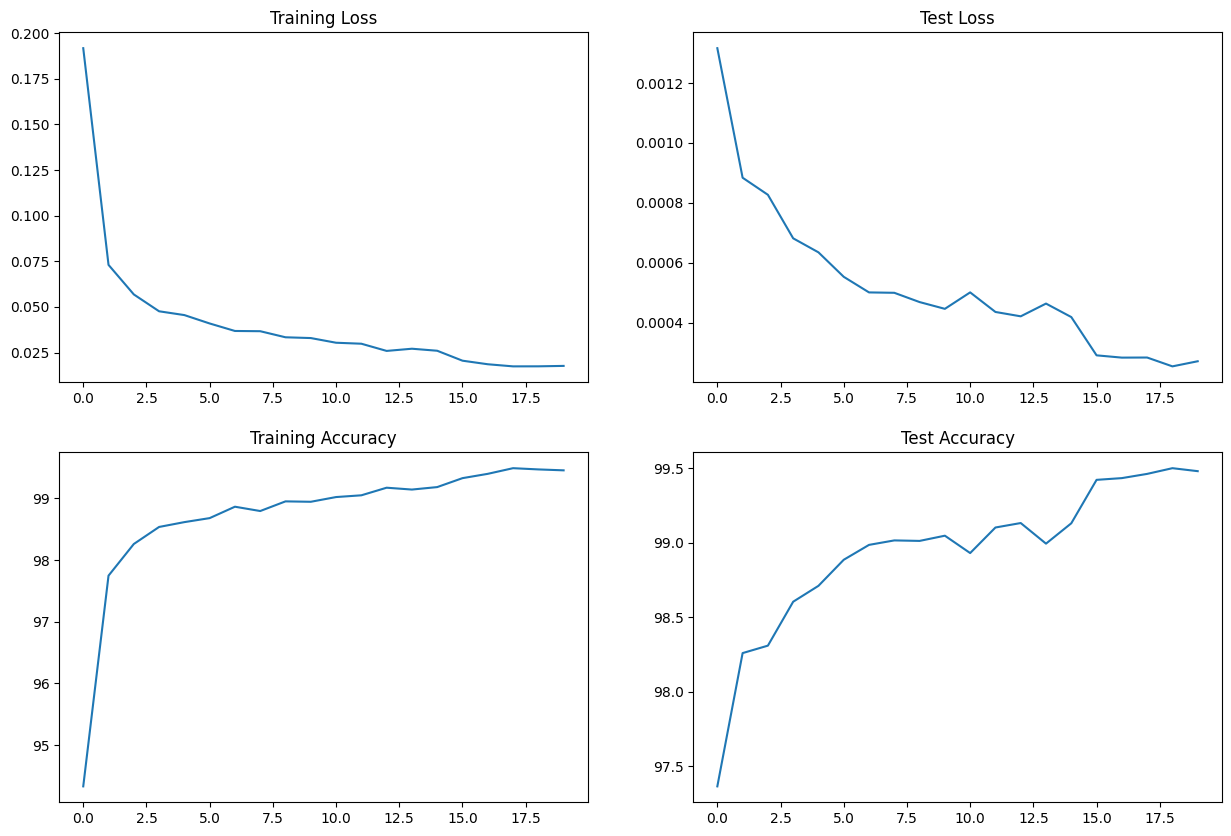

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 16, 24, 24]           4,624
       BatchNorm2d-4           [-1, 16, 24, 24]              32
            Conv2d-5           [-1, 16, 22, 22]           2,320
       BatchNorm2d-6           [-1, 16, 22, 22]              32
            Conv2d-7             [-1, 16, 9, 9]           2,320
       BatchNorm2d-8             [-1, 16, 9, 9]              32
            Conv2d-9             [-1, 16, 7, 7]           2,320
      BatchNorm2d-10             [-1, 16, 7, 7]              32
           Conv2d-11             [-1, 16, 3, 3]           2,320
      BatchNorm2d-12             [-1, 16, 3, 3]              32
           Conv2d-13             [-1, 12, 3, 3]           1,740
      BatchNorm2d-14             [-1, 1